[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mengyulin/CoastalEngineering/blob/master/Showcase/Chap_3/3_FlowField.ipynb)

## 載入 Python 函式庫

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 載入 Waves 模組 (求解頻散關係式)

In [2]:
class Waves:
    r"""
    Solves the wave dispersion relationship via Newton-Raphson.

    .. math::
        \omega^2 = gk\tanh kh

    Parameters
    ----------
    h : array_like, str
        Water depth [m] or 'deep', 'shallow' as keywords
    T : array_like
        Wave period [s]
    L : array_like
        Wave length [m]
    thetao : array_like
        TODO
    Ho : array_like
        TODO

    Returns
    -------
    omega : array_like
            Wave frequency
    TODO: hoLo, hoL, Lo, L, k, T, Co, C, Cg, G, Ks, Kr, theta, H

    Notes
    -----
    Compare values with:
    http://www.coastal.udel.edu/faculty/rad/wavetheory.html

    Examples
    --------
    >>> from oceans.sw_extras.waves import Waves
    >>> wav = Waves(h=10, T=5, L=None)
    >>> print(f"ho/Lo = {wav.hoLo:.3f}")
    ho/Lo = 0.256
    >>> print(f"ho/L  = {wav.hoL:.3f}")
    ho/L  = 0.273
    >>> print(f"Lo    = {wav.Lo:.3f}")
    Lo    = 39.033
    >>> print(f"L     = {wav.L:.3f}")
    L     = 36.593
    >>> print(f"k     = {wav.k:.3f}")
    k     = 0.172
    >>> print(f"omega = {wav.omega:.3f}")
    omega = 1.257
    >>> print(f"T     = {wav.T:.3f}")
    T     = 5.000
    >>> print(f"C     = {wav.C:.3f}")
    C     = 7.319
    >>> print(f"Cg    = {wav.Cg:.3f}")
    Cg    = 4.471
    >>> print(f"G     = {wav.G:.3f}")
    G     = 0.222
    >>> wav = Waves(h=10, T=None, L=100)
    >>> print(f"ho/Lo = {wav.hoLo:.3f}")
    ho/Lo = 0.056
    >>> print(f"ho/L  = {wav.hoL:.3f}")
    ho/L  = 0.100
    >>> print(f"Lo    = {wav.Lo:.3f}")
    Lo    = 179.568
    >>> print(f"L     = {wav.L:.3f}")
    L     = 100.000
    >>> print(f"k     = {wav.k:.3f}")
    k     = 0.063
    >>> print(f"omega = {wav.omega:.3f}")
    omega = 0.586
    >>> print(f"T     = {wav.T:.3f}")
    T     = 10.724
    >>> print(f"C     = {wav.C:.3f}")
    C     = 9.325
    >>> print(f"Cg    = {wav.Cg:.3f}")
    Cg    = 8.291
    >>> print(f"G     = {wav.G:.3f}")
    G     = 0.778
    >>> print(f"Ks  = {wav.Ks:.3f}")
    Ks  = 1.005

    """

    def __init__(self, h, T=None, L=None, thetao=None, Ho=None, lat=None):
        self.T = np.asarray(T, dtype=np.float64)
        self.L = np.asarray(L, dtype=np.float64)
        self.Ho = np.asarray(Ho, dtype=np.float64)
        self.lat = np.asarray(lat, dtype=np.float64)
        self.thetao = np.asarray(thetao, dtype=np.float64)

        if isinstance(h, str):
            if L is not None:
                if h == "deep":
                    self.h = self.L / 2.0
                elif h == "shallow":
                    self.h = self.L * 0.05
        else:
            self.h = np.asarray(h, dtype=np.float64)

        g = 9.81  # Default gravity.

        if L is None:
            self.omega = 2 * np.pi / self.T
            self.Lo = (g * self.T**2) / 2 / np.pi
            # Returns wavenumber of the gravity wave dispersion relation using
            # newtons method. The initial guess is shallow water wavenumber.
            self.k = self.omega / np.sqrt(g)
            # TODO: May change to,
            # self.k = self.w ** 2 / (g * np.sqrt(self.w ** 2 * self.h / g))
            f = g * self.k * np.tanh(self.k * self.h) - self.omega**2

            while np.abs(f.max()) > 1e-10:
                dfdk = g * self.k * self.h * (
                    1 / (np.cosh(self.k * self.h))
                ) ** 2 + g * np.tanh(self.k * self.h)
                self.k = self.k - f / dfdk
                # FIXME:
                f = g * self.k * np.tanh(self.k * self.h) - self.omega**2

            self.L = 2 * np.pi / self.k
            if isinstance(h, str):
                if h == "deep":
                    self.h = self.L / 2.0
                elif h == "shallow":
                    self.h = self.L * 0.05
        else:
            self.Lo = self.L / np.tanh(2 * np.pi * self.h / self.L)
            self.k = 2 * np.pi / self.L
            self.T = np.sqrt(2 * np.pi * self.Lo / g)
            self.omega = 2 * np.pi / self.T

        self.hoL = self.h / self.L
        self.hoLo = self.h / self.Lo
        self.C = self.omega / self.k  # or L / T
        self.Co = self.Lo / self.T
        self.G = 2 * self.k * self.h / np.sinh(2 * self.k * self.h)
        self.n = (1 + self.G) / 2
        self.Cg = self.n * self.C
        self.Ks = np.sqrt(1 / (1 + self.G) / np.tanh(self.k * self.h))

        if thetao is None:
            self.theta = np.NaN
            self.Kr = np.NaN
        if thetao is not None:
            self.theta = np.rad2deg(
                np.asin(self.C / self.Co * np.sin(np.deg2rad(self.thetao))),
            )
            self.Kr = np.sqrt(
                np.cos(np.deg2rad(self.thetao)) / np.cos(np.deg2rad(self.theta)),
            )

        if Ho is None:
            self.H = np.NaN
        if Ho is not None:
            self.H = self.Ho * self.Ks * self.Kr

## 微小振幅波之速度勢

\begin{equation}
\phi = \frac{gH}{2\omega}\frac{\cosh k(h+z)}{\cosh kh}\sin (kx-\omega t)
\end{equation}

### 使用 Waves 模組計算波長
設定波浪參數後計算波長 (或波數 $k$)。

In [3]:
g = 9.81                        # gravity
H = 1                           # wave height
h = 10                          # water depth
T = 5                           # wave period
omega = 2*np.pi/T               # angular frequency
wav = Waves(h=10, T=5, L=None)  # class Waves
k = wav.k                       # wave number
L = wav.L                       # wavelength

### 定義速度勢函式

In [4]:
def phi(x, z, t):
    return g*H/(2*np.pi) * np.cosh(k*(h+z))/np.cosh(k*h) * np.sin(k*x-omega*t)

### 定義水面高程函式

In [5]:
def eta(x,t):
    return H/2 * np.cos(k*x-omega*t)

### 繪出速度勢之等值線

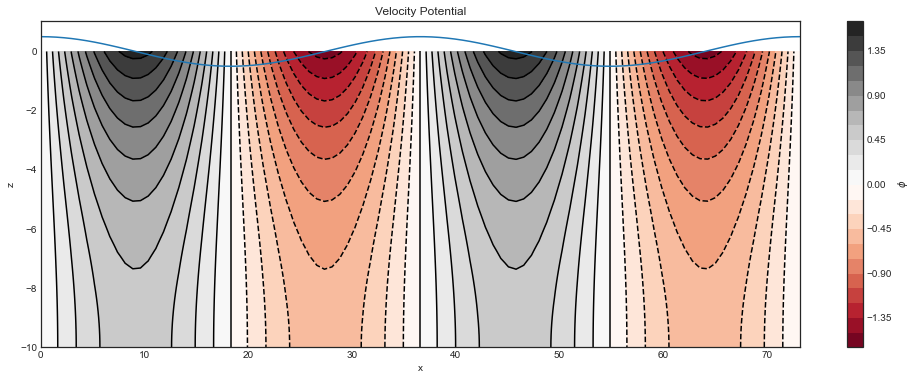

In [6]:
# Set time and output positions
t = 0
x = np.linspace(0, 2*L, 100)
z = np.linspace(0, -h, 50)
X, Z = np.meshgrid(x, z)

# Evaluate velocity potential at the output positions
phiField = phi(X, Z, t)

# Set figure
fig1, ax1 = plt.subplots(figsize=(17,6))

# Plot contours
CS1 = ax1.contour(X, Z, phiField, 20, colors='black');
CS2 = ax1.contourf(X, Z, phiField, 20, cmap='RdGy');

# Plot free surface
FS = ax1.plot(x,eta(x,t))

ax1.set_title('Velocity Potential');
ax1.set_xlabel('x');
ax1.set_ylabel('z');

cbar = fig1.colorbar(CS2);
cbar.ax.set_ylabel('$\phi$');

## 速度場

水粒子速度的水平和垂直分量 ($u$ 和 $w$) 可以從速度勢來決定:
\begin{equation}
u = \frac{\partial\phi}{\partial x},\quad w = \frac{\partial\phi}{\partial z}
\end{equation}
可得到
\begin{equation}
\label{eq:32}
u = \frac{H}{2}\omega \frac{\cosh k(h+z)}{\sinh kh}\cos (kx-\omega t)
\end{equation}
\begin{equation}
\label{eq:33}
w = \frac{H}{2}\omega \frac{\sinh k(h+z)}{\sinh kh}\sin (kx-\omega t)
\end{equation}

### 定義速度場函式

In [7]:
def velocity(x, z, t):
    u = H/2*omega * np.cosh(k*(h+z))/np.sinh(k*h) * np.cos(k*x-omega*t)
    v = H/2*omega * np.sinh(k*(h+z))/np.sinh(k*h) * np.sin(k*x-omega*t)
    return u, v

### 繪出速度向量

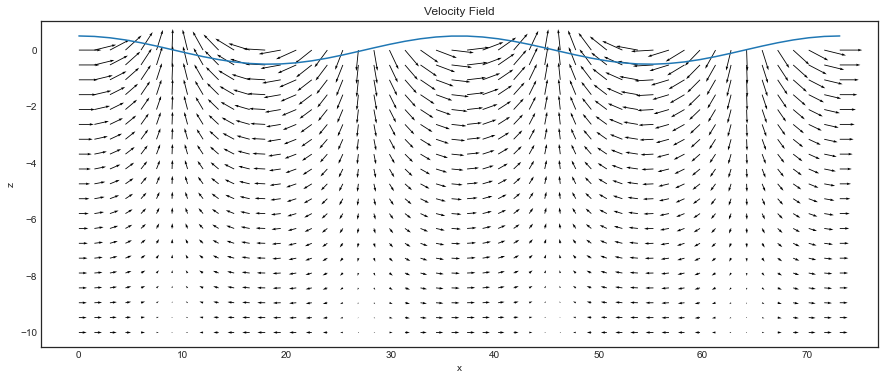

In [8]:
# Set time and output positions
t = 0
x = np.linspace(0, 2*L, 50)
z = np.linspace(0, -h, 20)
X, Z = np.meshgrid(x, z)

# Evaluate velocity potential at the output positions
U, V = velocity(X, Z, t)

# Set figure
fig2, ax2 = plt.subplots(figsize=(15,6))

# Plot contours
vec1 = ax2.quiver(X,Z,U,V,width=0.001,scale=1 / 0.08)

# Plot free surface
FS = ax2.plot(x,eta(x,t))

ax2.set_title('Velocity Field');
ax2.set_xlabel('x');
ax2.set_ylabel('z');

## 水粒子軌跡


\begin{equation}
x = x_1 + \frac{-H}{2}\frac{\cosh k(h+z_{1})}{\sinh kh}\sin (kx_{1}-\omega t)
\end{equation}
\begin{equation}
z = z_1 + \frac{H}{2}\frac{\sinh k(h+z_{1})}{\sinh kh}\cos (kx_{1}-\omega t)
\end{equation}


### 水粒子軌跡座標函式

In [9]:
def particleTrajectory(x1,z1,t):
    x = x1 - H/2 * np.cosh(k*(h+z1))/np.sinh(k*h) * np.sin(k*x1-omega*t)
    z = z1 + H/2 * np.sinh(k*(h+z1))/np.sinh(k*h) * np.cos(k*x1-omega*t)
    return x, z

### 繪出軌跡圖
以 x-z 等比例繪出一個週期之水粒子軌跡。

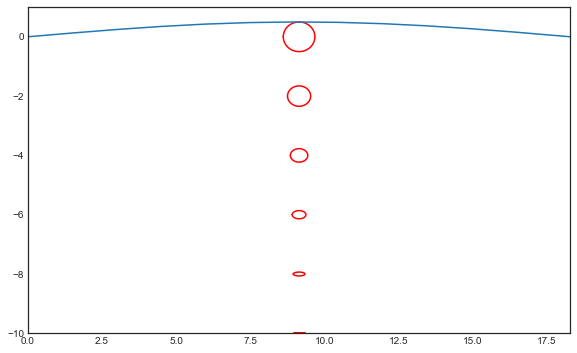

In [10]:
t = np.linspace(0, T, 50)
x1 = L/4
z1 = np.linspace(-h, 0, 6)

# Set figure
fig4, ax4 = plt.subplots(figsize=(15,6))
ax4.set_aspect("equal")
ax4.set_xlim(0,L/2)
ax4.set_ylim(-h,H)

for z2 in z1:
    XT, ZT = particleTrajectory(x1,z2,t)
    PT = ax4.plot(XT,ZT,'r')

# Plot free surface
FS4 = ax4.plot(x,eta(x,T/4))

## 壓力場

由 Bernoulli 方程式可以求得壓力場：
\begin{equation}
p = -\rho g z + \frac{\rho gH}{2}\frac{\cosh k(h+z)}{\cosh kh}\cos (kx-\omega t)
\end{equation}
式中右邊的第一項為液靜壓 (hydrostatic pressure) 之變化，第二個項是波浪引致之粒子加速度產生的動壓 (dynamic pressure) 變化。以下繪出動壓的分佈圖。

In [11]:
def dynPressure(x, z, t):
    rho = 1000
    return rho*g*H/2 * np.cosh(k*(h+z))/np.cosh(k*h) * np.cos(k*x-omega*t)

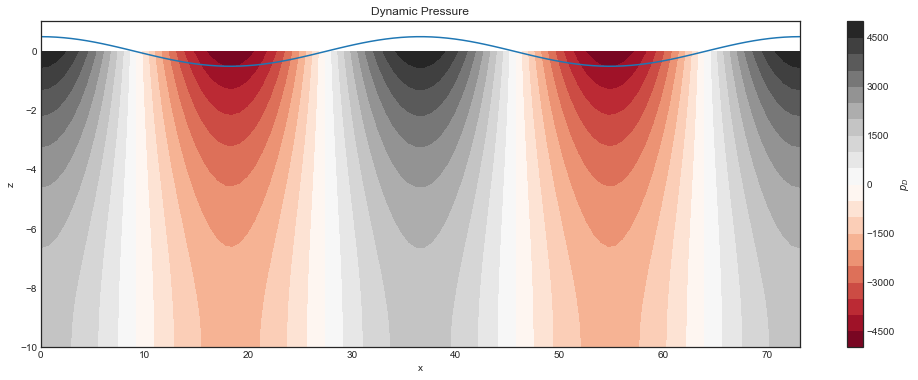

In [12]:
# Set time and output positions
t = 0
x = np.linspace(0, 2*L, 100)
z = np.linspace(0, -h, 50)
X, Z = np.meshgrid(x, z)

# Evaluate velocity potential at the output positions
pDField = dynPressure(X, Z, t)

# Set figure
fig3, ax3 = plt.subplots(figsize=(17,6))

# Plot contours
PD = ax3.contourf(X, Z, pDField, 20, cmap='RdGy');

# Plot free surface
FS = ax3.plot(x,eta(x,t))

ax3.set_title('Dynamic Pressure');
ax3.set_xlabel('x');
ax3.set_ylabel('z');

cbar = fig3.colorbar(PD);
cbar.ax.set_ylabel('$p_D$');